# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import sequence 
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Importing data from drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/gdrive/My Drive/IMDb_review_dataset/train_data.csv')
test_df = pd.read_csv('/gdrive/My Drive/IMDb_review_dataset/test_data.csv')

In [ ]:
display(train_df.head())
display(test_df.tail())

,File_index,Reviews,Rating,Label
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,10000,Homelessness (or Houselessness as George Carli...,8,1
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,10002,This is easily the most underrated film inn th...,7,1
4,10003,This is not the typical Mel Brooks film. It wa...,8,1


,File_index,Reviews,Rating,Label
24995,9998,I occasionally let my kids watch this garbage ...,1,0
24996,9999,When all we have anymore is pretty much realit...,1,0
24997,999,The basic genre is a thriller intercut with an...,3,0
24998,99,Four things intrigued me as to this film - fir...,3,0
24999,9,David Bryce's comments nearby are exceptionall...,4,0


In [ ]:
train_X = train_df['Reviews'].tolist()
test_X = test_df['Reviews'].tolist()
train_labels = train_df['Label']
test_labels = test_df['Label']

# Accuracy without preprocessing data

In [ ]:
wp_vectorizer = CountVectorizer(max_features=10000)
wp_cv_train = wp_vectorizer.fit_transform(train_X).toarray()
wp_cv_test = wp_vectorizer.fit_transform(test_X).toarray()

## Logistic regression

In [ ]:
wp_cv_log = LogisticRegression()
wp_cv_log.fit(wp_cv_train, train_labels)
wp_cv_log_pred = wp_cv_log.predict(wp_cv_test)
print(accuracy_score(wp_cv_log_pred, test_labels))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.52152


## Linear SVC

In [ ]:
wp_cv_svc = LinearSVC()
wp_cv_svc.fit(wp_cv_train, train_labels)
wp_cv_svc_pred = wp_cv_svc.predict(wp_cv_test)
print(accuracy_score(wp_cv_svc_pred, test_labels))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.52476


# DATA PREPROCESSING

## Removing html tags

In [ ]:
#remove html tags
def strip_html_tag(sample):
    cleanr = re.compile(r"\<[^\>]*\>|\\")
    return re.sub(cleanr, '', sample)

In [ ]:
train_X = list(map(strip_html_tag, train_X))
test_X = list(map(strip_html_tag, test_X))

## Converting all text to lowercase

In [ ]:
#Converting string to lower case
def string_lower(sample):
    sample.replace('.',' . ')
    return sample.lower()

In [ ]:
train_X = list(map(string_lower, train_X))
test_X = list(map(string_lower, test_X))

## Tokenize all texts

In [ ]:
# Tokenize
def tokenize_text(sample):
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(sample)

In [ ]:
train_X = list(map(tokenize_text,train_X))
test_X = list(map(tokenize_text,test_X))

## Remove stop words

In [ ]:
# Remove stop words
def stopword_remover(sample):
    stopwords_list = set(stopwords.words('english'))
    sample_wostopword = []
    for i in sample:
        if i not in stopwords_list:
            sample_wostopword.append(i) 
    return sample_wostopword

In [ ]:
train_X = list(map(stopword_remover,train_X))
test_X = list(map(stopword_remover,test_X))

## Remove punctuations

In [ ]:
# Remove punctuations
def punctuation_remover(sample):
    sample_wostopword_wopunc = []
    for i in sample:
        if i not in string.punctuation:
            sample_wostopword_wopunc.append(i)
    return sample_wostopword_wopunc

In [ ]:
train_X = list(map(punctuation_remover,train_X))
test_X = list(map(punctuation_remover,test_X))

## Adding parts of speech to each word

In [ ]:
# Parts of speech
def text_pos_tag(sample):
    return nltk.pos_tag(sample)

In [ ]:
train_X = list(map(text_pos_tag,train_X))
test_X = list(map(text_pos_tag,test_X))

## Lemmatize tokens

In [ ]:
def lemmatize(token):
    word, tag = token
    
    lemmatizer = WordNetLemmatizer()
    
    if word not in list(".,;'\"-"):
        return lemmatizer.lemmatize(word, get_wordnet_pos(tag))
    
    return word

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# Lemmatize all reviews
def lemmatized_text(sample):
    return list(map(lemmatize,sample))

In [ ]:
train_X = list(map(lemmatized_text,train_X))
test_X = list(map(lemmatized_text,test_X))

## Cleaned text

In [ ]:
# Combine token to form sentences as countvactorizer need sentence as input
train_X = list(map(lambda x: " ".join(x), train_X))
test_X = list(map(lambda x: " ".join(x), test_X))

In [ ]:
train_X[1]

"homelessness houselessness george carlin state issue year never plan help street consider human everything go school work vote matter people think homeless lose cause worry thing racism war iraq pressure kid succeed technology election inflation worry they'll next end streets.but give bet live street month without luxury home entertainment set bathroom picture wall computer everything treasure see like homeless goddard bolt's lesson.mel brook directs star bolt play rich man everything world decide make bet sissy rival jeffery tambor see live street thirty day without luxury bolt succeed want future project make building bet's bolt thrown street bracelet leg monitor every move can't step sidewalk he's give nickname pepto vagrant write forehead bolt meet character include woman name molly lesley ann warren ex-dancer get divorce losing home pal sailor howard morris fume teddy wilson already use street they're survivor bolt he's use reach mutual agreement like rich fight flight kill kille

# Convert text to document term matrix

## tfidf

In [ ]:
# keras text to matrix
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= 10000)
tokenizer.fit_on_texts(train_X)

In [ ]:
x_train = tokenizer.texts_to_matrix(train_X, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_X, mode='tfidf')

In [1]:
# print(x_train.shape)
# print(tokenizer.word_index)
# print(x_test.shape)

## Count Vectorizer

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
cv_train = vectorizer.fit_transform(train_X).toarray()
cv_test = vectorizer.fit_transform(test_X).toarray()

# Classifiers

## Model 1 - Multinomial Naive Bayes

In [ ]:
clf = MultinomialNB()
clf.fit(x_train, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Evaluation Metrics

In [ ]:
def conf_matrix(y_test,pred):
    conf_mat = confusion_matrix(y_test, pred)
    print(conf_mat)
    TN = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    TP = conf_mat[1][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    f1_score = (2*Precision*Recall)/(Precision + Recall)
    result = pd.DataFrame({'Accuracy':[Accuracy], 'Precision':[Precision], 'Recall':[Recall], 'f1_score':[f1_score]})
    print(result)

In [ ]:
mnb_pred_train = clf.predict(x_train)
conf_matrix(train_labels,mnb_pred_train)

[[11128  1372]
 [ 1827 10673]]
   Accuracy  Precision   Recall  f1_score
0   0.87204   0.886094  0.85384  0.869668


In [ ]:
mnb_pred_test = clf.predict(x_test)
conf_matrix(test_labels, mnb_pred_test)

[[10881  1619]
 [ 2932  9568]]
   Accuracy  Precision   Recall  f1_score
0   0.81796   0.855278  0.76544  0.807869


## Model 2 - Logistic Regression

In [ ]:
log = LogisticRegression(solver = 'newton-cg')
log.fit(x_train, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_pred_train = log.predict(x_train)
conf_matrix(train_labels, log_pred_train)

[[12500     0]
 [    0 12500]]
   Accuracy  Precision  Recall  f1_score
0       1.0        1.0     1.0       1.0


In [ ]:
log_pred_test = log.predict(x_test)
conf_matrix(test_labels, log_pred_test)

[[10612  1888]
 [ 2318 10182]]
   Accuracy  Precision   Recall  f1_score
0   0.83176   0.843579  0.81456  0.828816


In [ ]:
def logisticregression(thres):
  clf = LogisticRegression(solver = 'lbfgs')
  clf.fit(x_train, train_labels)
  pred = (clf.predict_proba(x_test)[:,1]>=thres)
  conf_mat = confusion_matrix(pred, test_labels)
  acc = accuracy_score(pred, test_labels)
  TN = conf_mat[0][0]
  FP = conf_mat[0][1]
  FN = conf_mat[1][0]
  TP = conf_mat[1][1]
  Accuracy = (TP+TN)/(TP+FP+TN+FN)
  Error = (FP+FN)/(TP+FP+TN+FN)
  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  return pd.Series([i, Accuracy, Error, Precision, Recall], 
                       index=["Threshold",'Accuracy', 'Error', 'Precision', 'Recall'])
    

In [ ]:
log_df = pd.DataFrame(columns=["Threshold",'Accuracy', 'Error', 'Precision', 'Recall'])
log_thres = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in log_thres:
    log_df = log_df.append(logisticregression(i),ignore_index=True)
display(log_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

,Threshold,Accuracy,Error,Precision,Recall
0,0.2,0.83164,0.16836,0.84968,0.820091
1,0.3,0.83228,0.16772,0.83672,0.829355
2,0.4,0.83248,0.16752,0.82616,0.836736
3,0.5,0.83204,0.16796,0.81480,0.843898
4,0.6,0.83116,0.16884,0.80384,0.850300
5,0.7,0.83132,0.16868,0.79400,0.858044
6,0.8,0.82816,0.17184,0.77624,0.866185
7,0.9,0.82140,0.17860,0.74848,0.876276


## Model 3 - LDA

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [ ]:
lda_pred_train = lda.predict(x_train)
conf_matrix(train_labels, lda_pred_train)

[[11963   537]
 [  441 12059]]
   Accuracy  Precision   Recall  f1_score
0   0.96088   0.957367  0.96472   0.96103


In [ ]:
lda_pred_test = lda.predict(x_test)
conf_matrix(test_labels, lda_pred_test)

[[10045  2455]
 [ 2783  9717]]
   Accuracy  Precision   Recall  f1_score
0   0.79048   0.798308  0.77736  0.787695


## Model 4- Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
dt_pred_train = dt.predict(x_train)
conf_matrix(train_labels, dt_pred_train)

[[12500     0]
 [    0 12500]]
   Accuracy  Precision  Recall  f1_score
0       1.0        1.0     1.0       1.0


In [ ]:
dt_pred_test = dt.predict(x_test)
conf_matrix(test_labels, dt_pred_test)

[[9073 3427]
 [3548 8952]]
   Accuracy  Precision   Recall  f1_score
0     0.721    0.72316  0.71616  0.719643


## Model 5 - Linear SVC

In [ ]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
linear_svc_pred_train =linear_svc.predict(x_train)
conf_matrix(train_labels,linear_svc_pred_train)

[[12500     0]
 [    0 12500]]
   Accuracy  Precision  Recall  f1_score
0       1.0        1.0     1.0       1.0


In [ ]:
linear_svc_pred_test =linear_svc.predict(x_test)
conf_matrix(test_labels,linear_svc_pred_test)

[[10466  2034]
 [ 2511  9989]]
   Accuracy  Precision   Recall  f1_score
0    0.8182   0.830824  0.79912  0.814664


# Ensemble Learning

## Model - Random Forest

In [ ]:
def Random_Forest(estimators, dataset):
    clf = RandomForestClassifier(n_estimators=estimators)
    clf.fit(x_train, train_labels)
    if dataset == "train":
        pred = clf.predict(x_train)
        conf_mat = confusion_matrix(train_labels, pred)
    else:
        pred = clf.predict(x_test)
        conf_mat = confusion_matrix(test_labels, pred)
    TN = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    TP = conf_mat[1][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Error = (FP+FN)/(TP+FP+TN+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    result = pd.Series([dataset, estimators, Accuracy, Error, Precision, Recall], 
                       index=['Dataset','Estimators','Accuracy', 'Error', 'Precision', 'Recall'])
    return result

In [ ]:
random_forest_df = pd.DataFrame(columns=['Dataset','Estimators','Accuracy', 'Error', 'Precision', 'Recall'])
estimators = [10,50,200,500]
dataset = ['train','test']
for i in estimators:
    for j in dataset:
        random_forest_df = random_forest_df.append(Random_Forest(i,j),ignore_index=True)
display(random_forest_df)

,Dataset,Estimators,Accuracy,Error,Precision,Recall
0,train,10,0.99364,0.00636,0.998304,0.98896
1,test,10,0.77460,0.22540,0.818325,0.70592
2,train,50,1.00000,0.00000,1.000000,1.00000
3,test,50,0.83592,0.16408,0.845029,0.82272
4,train,200,1.00000,0.00000,1.000000,1.00000
5,test,200,0.85276,0.14724,0.858467,0.84480
6,train,500,1.00000,0.00000,1.000000,1.00000
7,test,500,0.85884,0.14116,0.859905,0.85736


## Model - Adaboost

In [ ]:
def Adaboost(estimators, dataset):
    clf = AdaBoostClassifier(n_estimators= estimators)
    clf.fit(x_train, train_labels)
    if dataset == "train":
        pred = clf.predict(x_train)
        conf_mat = confusion_matrix(pred,train_labels)
    else:
        pred = clf.predict(x_test)
        conf_mat = confusion_matrix(pred,test_labels)
    TN = conf_mat[0][0]
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    TP = conf_mat[1][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Error = (FP+FN)/(TP+FP+TN+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    result = pd.Series([dataset, estimators, Accuracy, Error, Precision, Recall], 
                       index=['Dataset','Estimators','Accuracy', 'Error', 'Precision', 'Recall'])
    return result

In [ ]:
adaboost_df = pd.DataFrame(columns=['Dataset','Estimators','Accuracy', 'Error', 'Precision', 'Recall'])
estimators = [10]
dataset = ['train','test']
for i in estimators:
    for j in dataset:
        adaboost_df = adaboost_df.append(Adaboost(i,j),ignore_index=True)
display(adaboost_df)

,Dataset,Estimators,Accuracy,Error,Precision,Recall
0,train,10,0.72192,0.27808,0.86768,0.671829
1,test,10,0.72896,0.27104,0.86472,0.680068


## Model - Adaboost with logistic regression

In [ ]:
log_adaboost = AdaBoostClassifier(base_estimator=LogisticRegression(solver = 'lbfgs'), n_estimators=12)
log_adaboost.fit(x_train, train_labels)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     l1_ratio=None,
                                                     max_iter=100,
                                                     multi_class='warn',
                                                     n_jobs=None, penalty='l2',
                                                     random_state=None,
                                                     solver='lbfgs', tol=0.0001,
                                                     verbose=0,
                                                     warm_start=False),
                   learning_rate=1.0, n_estimators=12, random_state=None)

In [ ]:
log_adaboost_pred_train = log_adaboost.predict(x_train)
conf_matrix(train_labels,log_adaboost_pred_train)

[[11485  1015]
 [  809 11691]]
   Accuracy  Precision   Recall  f1_score
0   0.92704   0.920116  0.93528  0.927636


In [ ]:
log_adaboost_pred_test = log_adaboost.predict(x_test)
conf_matrix(test_labels,log_adaboost_pred_test)

[[11068  1432]
 [ 1450 11050]]
   Accuracy  Precision  Recall  f1_score
0   0.88472   0.885275   0.884  0.884637


# ROC

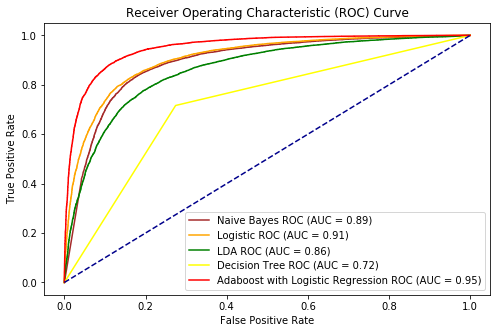

In [ ]:
plt.figure(figsize=(8,5))
nb_pred_prob = clf.predict_proba(x_test)
nb_pred_prob = nb_pred_prob[:,1]
auc = roc_auc_score(test_labels, nb_pred_prob)
fpr, tpr,thres = roc_curve(test_labels,nb_pred_prob)
plt.plot(fpr, tpr, color='brown', label='Naive Bayes ROC (AUC = %0.2f)' % auc)

logreg_pred_prob = log.predict_proba(x_test)
logreg_pred_prob = logreg_pred_prob[:,1]
auc = roc_auc_score(test_labels, logreg_pred_prob)
fpr, tpr,thres = roc_curve(test_labels,logreg_pred_prob)
plt.plot(fpr, tpr, color='orange', label='Logistic ROC (AUC = %0.2f)' % auc)

lda_pred_prob = lda.predict_proba(x_test)
lda_pred_prob = lda_pred_prob[:,1]
auc = roc_auc_score(test_labels, lda_pred_prob)
fpr, tpr,thres = roc_curve(test_labels,lda_pred_prob)
plt.plot(fpr, tpr, color='green', label='LDA ROC (AUC = %0.2f)' % auc)

dt_pred_prob = dt.predict_proba(x_test)
dt_pred_prob = dt_pred_prob[:,1]
auc = roc_auc_score(test_labels, dt_pred_prob)
fpr, tpr,thres = roc_curve(test_labels,dt_pred_prob)
plt.plot(fpr, tpr, color='yellow', label='Decision Tree ROC (AUC = %0.2f)' % auc)

log_adaboost_pred = log_adaboost.predict_proba(x_test)
log_adaboost_pred = log_adaboost_pred[:,1]
auc = roc_auc_score(test_labels, log_adaboost_pred)
fpr, tpr,thres = roc_curve(test_labels,log_adaboost_pred)
plt.plot(fpr, tpr, color='red', label='Adaboost with Logistic Regression ROC (AUC = %0.2f)' % auc)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# FF Neural network

In [ ]:
x_train_ffnn = tf.keras.utils.normalize(x_train, axis=1)
x_test_ffnn = tf.keras.utils.normalize(x_test, axis=1)

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
def ffnn(x_train,y_train): 
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(8000, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(6000, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(2000, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
  model.compile(optimizer = 'adam' , 
                loss ='sparse_categorical_crossentropy', 
                metrics = ['accuracy'])
  model.fit(x_train,y_train, epochs =3)
  return model

In [2]:
ffnn_model = ffnn(x_train_ffnn,y_train)

In [ ]:
ffnn_pred_train = ffnn_model.predict(x_train_ffnn)
ffnn_pred_train = ffnn_pred_train[:,1]>=0.5
conf_matrix(train_labels,ffnn_pred_train)

[[12496     4]
 [   38 12462]]
   Accuracy  Precision   Recall  f1_score
0   0.99832   0.999679  0.99696  0.998318


In [ ]:
ffnn_pred_test = ffnn_model.predict(x_test_ffnn)
ffnn_pred_test = ffnn_pred_test[:,1]>=0.5
conf_matrix(test_labels,ffnn_pred_test)

[[11290  1210]
 [ 2587  9913]]
   Accuracy  Precision   Recall  f1_score
0   0.84812   0.891216  0.79304  0.839267
